# Depression Level Prediction – Fast Execution Notebook

# Depression Level Prediction – Fast Execution Notebook
Target: **Depression Label**. Streamlined training & evaluation.

In [21]:
# 1. Imports & Config
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib
RANDOM_STATE=42; np.random.seed(RANDOM_STATE)
DATA_PATH=Path('../data/raw/stress_data.csv')
TARGET='Depression Label'
MODEL_DIR=Path('../models'); MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR=Path('../reports/results'); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Config ready.')

Config ready.


In [22]:
# 2. Load & Clean
if not DATA_PATH.exists(): raise FileNotFoundError(DATA_PATH)
df=pd.read_csv(DATA_PATH)
if TARGET not in df.columns: raise KeyError(f'Missing target {TARGET}')
for c in df.select_dtypes(include='object').columns: df[c]=df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
print('Shape:', df.shape)
print('Classes:', df[TARGET].unique())

Shape: (1977, 39)
Classes: ['Moderate Depression' 'Mild Depression' 'Moderately Severe Depression'
 'Minimal Depression' 'Severe Depression' 'No Depression']


In [11]:
# 3. Preprocess
def split_num_cat(data,target):
 nums,cats=[],[]
 for col in data.columns:
  if col==target: continue
  (nums if pd.api.types.is_numeric_dtype(data[col]) else cats).append(col)
 return nums,cats
num_cols,cat_cols=split_num_cat(df,TARGET)
from sklearn.impute import SimpleImputer
num_pipe=Pipeline([('imp',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe=Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre=ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])
label_encoder=LabelEncoder(); y=label_encoder.fit_transform(df[TARGET].astype(str)); X=df.drop(columns=[TARGET])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

Train/Test: (1581, 38) (396, 38)


In [12]:
# 4. Baseline
def metrics(y_true,y_pred): return {'accuracy':accuracy_score(y_true,y_pred),'precision_weighted':precision_score(y_true,y_pred,average='weighted',zero_division=0),'recall_weighted':recall_score(y_true,y_pred,average='weighted',zero_division=0),'f1_weighted':f1_score(y_true,y_pred,average='weighted',zero_division=0)}
baseline=Pipeline([('pre',pre),('clf',DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train,y_train); base_pred=baseline.predict(X_test)
print('Baseline:', metrics(y_test, base_pred))

Baseline: {'accuracy': 0.25, 'precision_weighted': 0.0625, 'recall_weighted': 0.25, 'f1_weighted': 0.1}


In [13]:
# 5. Train Candidates
cands={'logreg':LogisticRegression(max_iter=400),'rf':RandomForestClassifier(n_estimators=120,random_state=RANDOM_STATE),'gb':GradientBoostingClassifier(random_state=RANDOM_STATE),'svc':SVC(probability=True,random_state=RANDOM_STATE)}
results={}; models={}
for name,clf in cands.items():
 pipe=Pipeline([('pre',pre),('clf',clf)])
 t0=time.time(); pipe.fit(X_train,y_train); pred=pipe.predict(X_test)
 m=metrics(y_test,pred); m['train_time_sec']=round(time.time()-t0,2); results[name]=m; models[name]=pipe; print(name,m)
import pandas as pd
res_df=pd.DataFrame(results).T.sort_values('f1_weighted',ascending=False); print(res_df)

logreg {'accuracy': 0.9166666666666666, 'precision_weighted': 0.9143839035667409, 'recall_weighted': 0.9166666666666666, 'f1_weighted': 0.9151466755273452, 'train_time_sec': 0.61}
rf {'accuracy': 0.9848484848484849, 'precision_weighted': 0.9847338960585426, 'recall_weighted': 0.9848484848484849, 'f1_weighted': 0.9845431356126545, 'train_time_sec': 1.04}
rf {'accuracy': 0.9848484848484849, 'precision_weighted': 0.9847338960585426, 'recall_weighted': 0.9848484848484849, 'f1_weighted': 0.9845431356126545, 'train_time_sec': 1.04}
gb {'accuracy': 1.0, 'precision_weighted': 1.0, 'recall_weighted': 1.0, 'f1_weighted': 1.0, 'train_time_sec': 7.75}
gb {'accuracy': 1.0, 'precision_weighted': 1.0, 'recall_weighted': 1.0, 'f1_weighted': 1.0, 'train_time_sec': 7.75}
svc {'accuracy': 0.9166666666666666, 'precision_weighted': 0.9192678896683902, 'recall_weighted': 0.9166666666666666, 'f1_weighted': 0.9164452991426509, 'train_time_sec': 1.95}
        accuracy  precision_weighted  recall_weighted  f1_w

Best model: gb
                              precision    recall  f1-score   support

             Mild Depression       1.00      1.00      1.00        82
          Minimal Depression       1.00      1.00      1.00        18
         Moderate Depression       1.00      1.00      1.00        90
Moderately Severe Depression       1.00      1.00      1.00        99
               No Depression       1.00      1.00      1.00         9
           Severe Depression       1.00      1.00      1.00        98

                    accuracy                           1.00       396
                   macro avg       1.00      1.00      1.00       396
                weighted avg       1.00      1.00      1.00       396



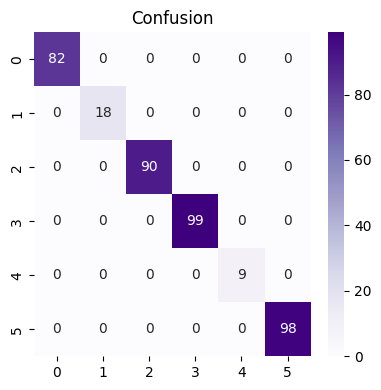

Sample labels: ['Moderately Severe Depression' 'Mild Depression' 'Mild Depression'
 'Moderately Severe Depression' 'Minimal Depression' 'No Depression'
 'Severe Depression' 'Severe Depression' 'Moderate Depression'
 'Mild Depression']
Saved artifact & metrics.


In [14]:
# 6. Persist & Report
best_name=res_df.index[0]; best_model=models[best_name]
y_best=best_model.predict(X_test)
print('Best model:', best_name)
print(classification_report(y_test,y_best,zero_division=0,target_names=label_encoder.classes_))
cm=confusion_matrix(y_test,y_best)
plt.figure(figsize=(4,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Purples'); plt.title('Confusion'); plt.tight_layout(); plt.show()
artifact={'model':best_model,'label_encoder':label_encoder,'classes':list(label_encoder.classes_),'metrics_table':res_df.to_dict(),'best_model_name':best_name,'timestamp':dt.datetime.utcnow().isoformat()}
joblib.dump(artifact, MODEL_DIR/'best_depression_model_fast.joblib')
res_df.to_csv(RESULTS_DIR/'depression_model_metrics_fast.csv')
sample=best_model.predict(X_test[:10])
print('Sample labels:', label_encoder.inverse_transform(sample))
print('Saved artifact & metrics.')

# 📊 Comprehensive Model Performance Visualizations

Let's create detailed visual comparisons of our model performance and insights.

<Figure size 1500x1000 with 0 Axes>

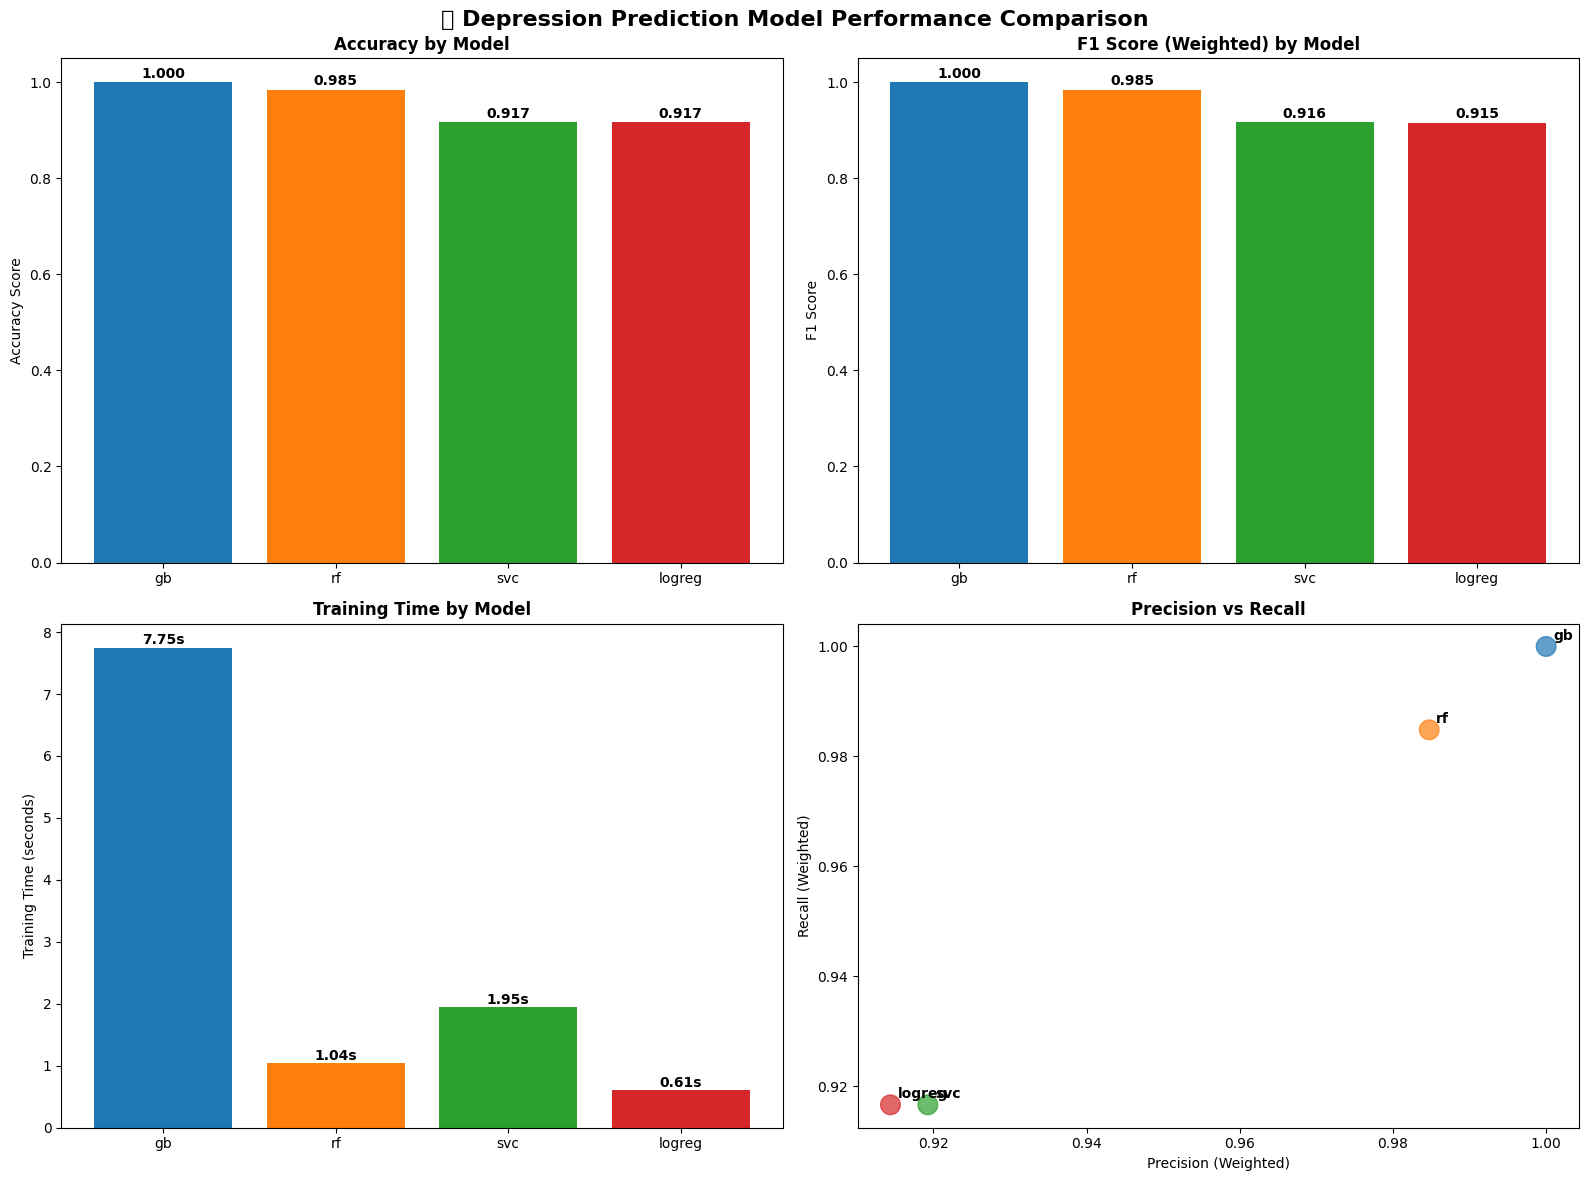

📈 Model Performance Summary:
🤖 GB: Accuracy=1.000, F1=1.000, Time=7.75s
🤖 RF: Accuracy=0.985, F1=0.985, Time=1.04s
🤖 SVC: Accuracy=0.917, F1=0.916, Time=1.95s
🤖 LOGREG: Accuracy=0.917, F1=0.915, Time=0.61s


In [16]:
# Model Performance Comparison Bar Chart
plt.figure(figsize=(15, 10))

# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔍 Depression Prediction Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
axes[0,0].bar(res_df.index, res_df['accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,0].set_title('Accuracy by Model', fontweight='bold')
axes[0,0].set_ylabel('Accuracy Score')
axes[0,0].set_ylim(0, 1.05)
for i, v in enumerate(res_df['accuracy']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# F1 Score comparison
axes[0,1].bar(res_df.index, res_df['f1_weighted'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,1].set_title('F1 Score (Weighted) by Model', fontweight='bold')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_ylim(0, 1.05)
for i, v in enumerate(res_df['f1_weighted']):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Training Time comparison
axes[1,0].bar(res_df.index, res_df['train_time_sec'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1,0].set_title('Training Time by Model', fontweight='bold')
axes[1,0].set_ylabel('Training Time (seconds)')
for i, v in enumerate(res_df['train_time_sec']):
    axes[1,0].text(i, v + 0.05, f'{v:.2f}s', ha='center', fontweight='bold')

# Precision vs Recall scatter
axes[1,1].scatter(res_df['precision_weighted'], res_df['recall_weighted'], 
                  s=200, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
axes[1,1].set_title('Precision vs Recall', fontweight='bold')
axes[1,1].set_xlabel('Precision (Weighted)')
axes[1,1].set_ylabel('Recall (Weighted)')
for i, model in enumerate(res_df.index):
    axes[1,1].annotate(model, (res_df['precision_weighted'][i], res_df['recall_weighted'][i]),
                       xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 Model Performance Summary:")
print("="*50)
for model in res_df.index:
    print(f"🤖 {model.upper()}: Accuracy={res_df.loc[model, 'accuracy']:.3f}, "
          f"F1={res_df.loc[model, 'f1_weighted']:.3f}, "
          f"Time={res_df.loc[model, 'train_time_sec']:.2f}s")

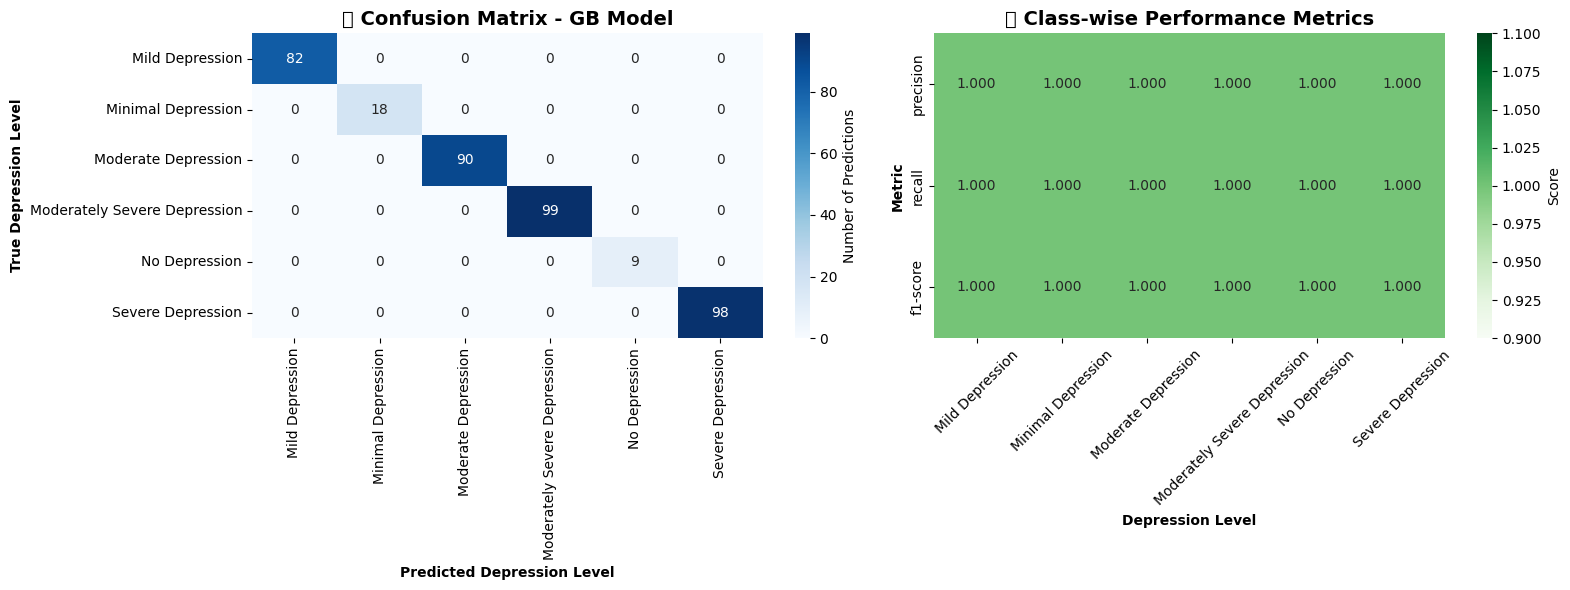

🔍 DETAILED CLASSIFICATION INSIGHTS:
📋 Mild Depression:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 82 samples

📋 Minimal Depression:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 18 samples

📋 Moderate Depression:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 90 samples

📋 Moderately Severe Depression:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 99 samples

📋 No Depression:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 9 samples

📋 Severe Depression:
   • Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
   • Support: 98 samples



In [17]:
# Enhanced Confusion Matrix with Class-wise Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Enhanced Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            ax=axes[0], cbar_kws={'label': 'Number of Predictions'})
axes[0].set_title(f'🎯 Confusion Matrix - {best_name.upper()} Model', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Predicted Depression Level', fontweight='bold')
axes[0].set_ylabel('True Depression Level', fontweight='bold')

# Class-wise Accuracy Heatmap
from sklearn.metrics import classification_report
report = classification_report(y_test, y_best, target_names=label_encoder.classes_, output_dict=True)
class_metrics = pd.DataFrame(report).T.iloc[:-3]  # Remove macro/weighted avg rows

sns.heatmap(class_metrics[['precision', 'recall', 'f1-score']].T, 
            annot=True, fmt='.3f', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Score'})
axes[1].set_title('📊 Class-wise Performance Metrics', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Depression Level', fontweight='bold')
axes[1].set_ylabel('Metric', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed classification insights
print("🔍 DETAILED CLASSIFICATION INSIGHTS:")
print("="*60)
for class_name in label_encoder.classes_:
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = int(report[class_name]['support'])
        print(f"📋 {class_name}:")
        print(f"   • Precision: {precision:.3f} | Recall: {recall:.3f} | F1-Score: {f1:.3f}")
        print(f"   • Support: {support} samples")
        print()

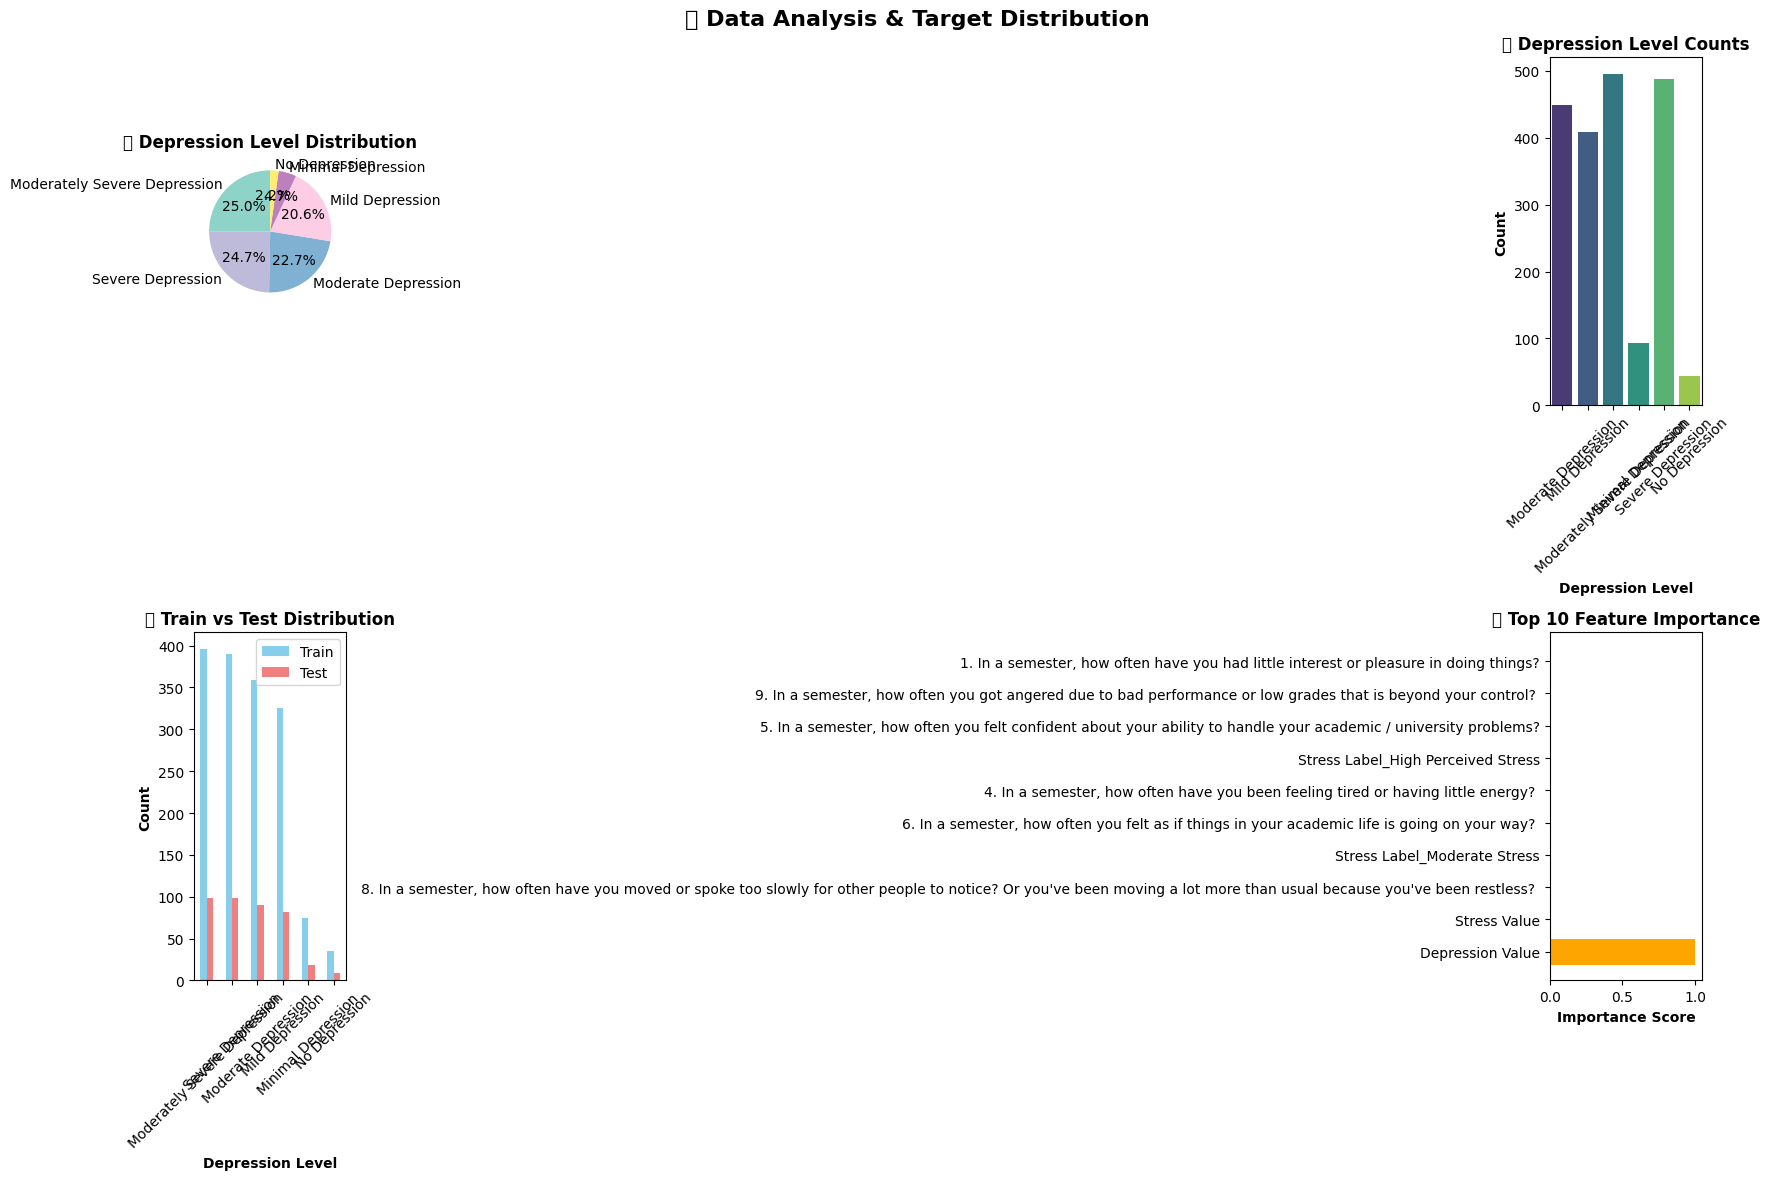

📊 DATASET STATISTICS:
📝 Total Samples: 1,977
🔢 Features: 38
📊 Classes: 6
⚖️ Train/Test Split: 1,581 / 396
🎯 Most Common Class: Moderately Severe Depression (25.0%)


In [18]:
# Data Distribution and Target Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📈 Data Analysis & Target Distribution', fontsize=16, fontweight='bold')

# Target distribution pie chart
target_counts = df[TARGET].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(target_counts)))
axes[0,0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
              startangle=90, colors=colors)
axes[0,0].set_title('🎯 Depression Level Distribution', fontweight='bold')

# Target distribution bar chart
sns.countplot(data=df, x=TARGET, ax=axes[0,1], palette='viridis')
axes[0,1].set_title('📊 Depression Level Counts', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_xlabel('Depression Level', fontweight='bold')
axes[0,1].set_ylabel('Count', fontweight='bold')

# Train vs Test distribution
train_dist = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
test_dist = pd.Series(label_encoder.inverse_transform(y_test)).value_counts()
comparison_df = pd.DataFrame({'Train': train_dist, 'Test': test_dist}).fillna(0)
comparison_df.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'lightcoral'])
axes[1,0].set_title('🔄 Train vs Test Distribution', fontweight='bold')
axes[1,0].set_xlabel('Depression Level', fontweight='bold')
axes[1,0].set_ylabel('Count', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()

# Feature importance (if available)
try:
    if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
        # Get feature names after preprocessing
        feature_names = (num_cols + 
                        list(best_model.named_steps['pre'].named_transformers_['cat']
                             .named_steps['ohe'].get_feature_names_out(cat_cols)))
        importances = best_model.named_steps['clf'].feature_importances_
        
        # Top 10 features
        top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:10]
        feature_names_top, importance_values = zip(*top_features)
        
        axes[1,1].barh(range(len(feature_names_top)), importance_values, color='orange')
        axes[1,1].set_yticks(range(len(feature_names_top)))
        axes[1,1].set_yticklabels(feature_names_top)
        axes[1,1].set_title('🔍 Top 10 Feature Importance', fontweight='bold')
        axes[1,1].set_xlabel('Importance Score', fontweight='bold')
    else:
        axes[1,1].text(0.5, 0.5, f'Feature importance not available\nfor {best_name} model', 
                       ha='center', va='center', transform=axes[1,1].transAxes,
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1,1].set_title('🔍 Feature Importance', fontweight='bold')
except Exception as e:
    axes[1,1].text(0.5, 0.5, f'Feature importance\nanalysis failed:\n{str(e)[:50]}...', 
                   ha='center', va='center', transform=axes[1,1].transAxes,
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    axes[1,1].set_title('🔍 Feature Importance', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 DATASET STATISTICS:")
print("="*40)
print(f"📝 Total Samples: {len(df):,}")
print(f"🔢 Features: {len(df.columns)-1}")
print(f"📊 Classes: {len(df[TARGET].unique())}")
print(f"⚖️ Train/Test Split: {len(X_train):,} / {len(X_test):,}")
print(f"🎯 Most Common Class: {df[TARGET].mode()[0]} ({df[TARGET].value_counts().iloc[0]/len(df)*100:.1f}%)")

🎯 Average Prediction Confidence: 1.000
📊 Confidence Range: 1.000 - 1.000


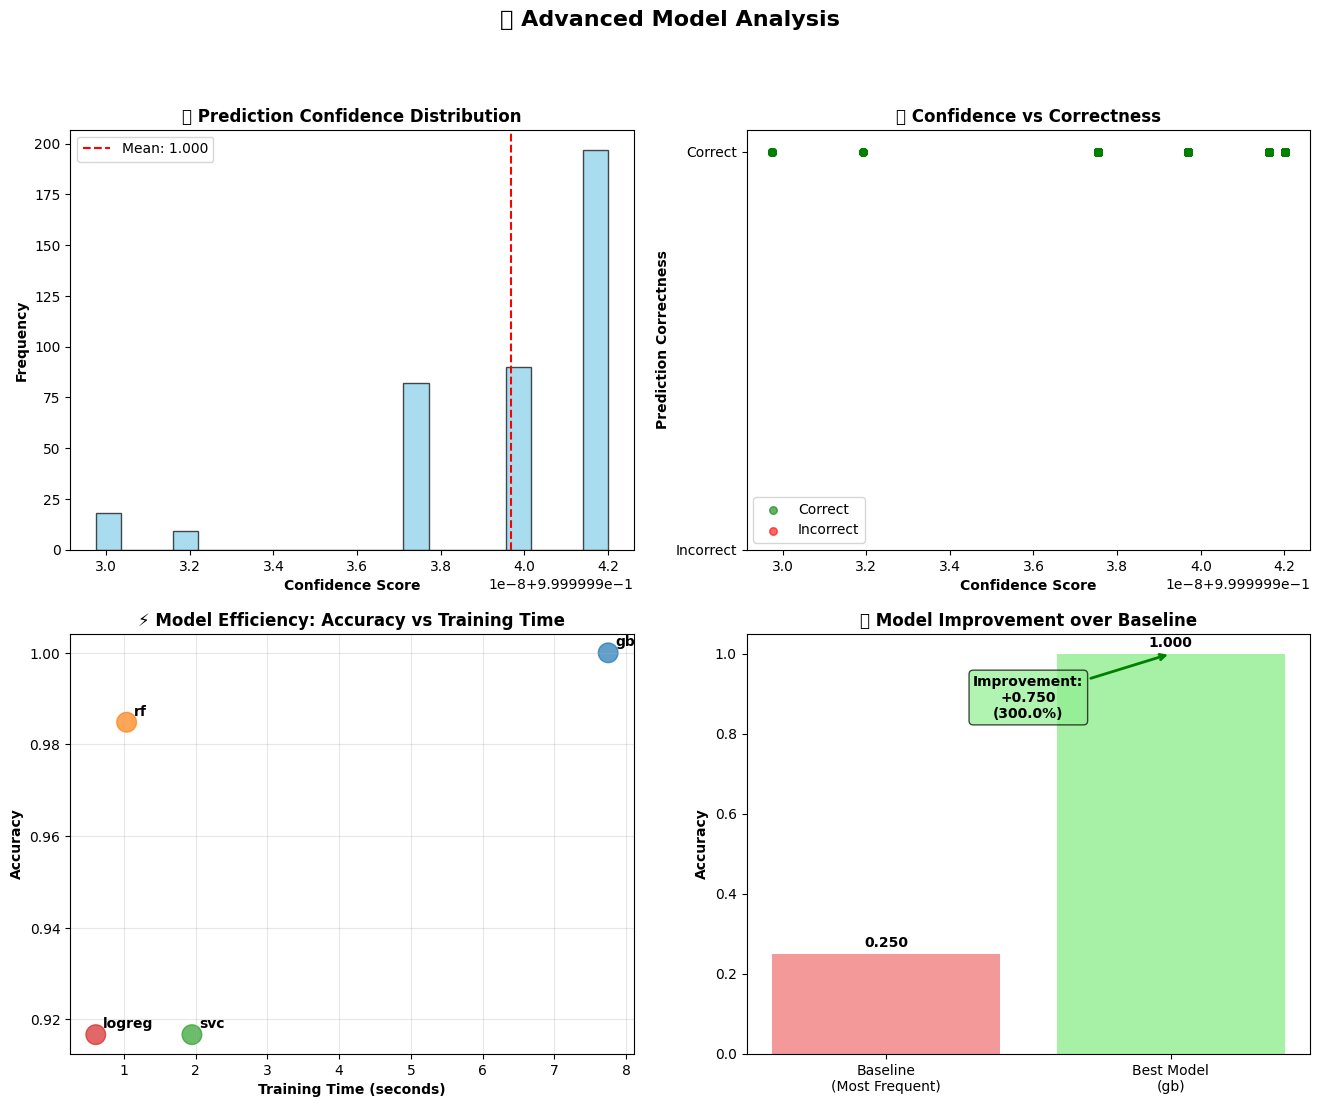

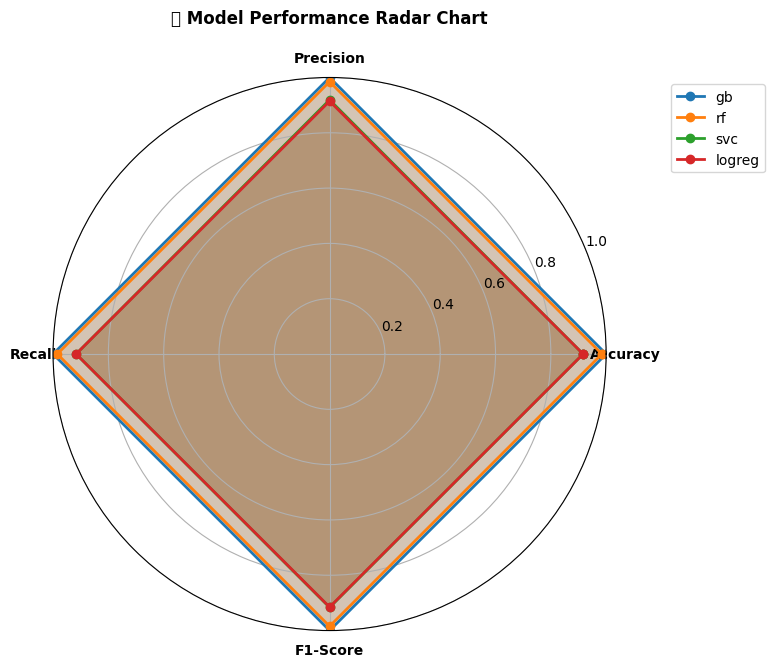

🚀 MODEL IMPROVEMENT SUMMARY:
📈 Baseline Accuracy: 0.250
🏆 Best Model Accuracy: 1.000
⬆️  Improvement: 0.750 (300.0%)


In [19]:
# Advanced Analysis: Prediction Confidence & ROC Curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🧠 Advanced Model Analysis', fontsize=16, fontweight='bold')

# Prediction Confidence Distribution
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)
    confidence_scores = np.max(y_proba, axis=1)
    
    axes[0,0].hist(confidence_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(np.mean(confidence_scores), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(confidence_scores):.3f}')
    axes[0,0].set_title('🎯 Prediction Confidence Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Confidence Score', fontweight='bold')
    axes[0,0].set_ylabel('Frequency', fontweight='bold')
    axes[0,0].legend()
    
    # Confidence vs Accuracy
    correct_predictions = (y_best == y_test)
    axes[0,1].scatter(confidence_scores[correct_predictions], [1]*sum(correct_predictions), 
                      alpha=0.6, color='green', label='Correct', s=30)
    axes[0,1].scatter(confidence_scores[~correct_predictions], [0]*sum(~correct_predictions), 
                      alpha=0.6, color='red', label='Incorrect', s=30)
    axes[0,1].set_title('📊 Confidence vs Correctness', fontweight='bold')
    axes[0,1].set_xlabel('Confidence Score', fontweight='bold')
    axes[0,1].set_ylabel('Prediction Correctness', fontweight='bold')
    axes[0,1].set_yticks([0, 1])
    axes[0,1].set_yticklabels(['Incorrect', 'Correct'])
    axes[0,1].legend()
    
    print(f"🎯 Average Prediction Confidence: {np.mean(confidence_scores):.3f}")
    print(f"📊 Confidence Range: {np.min(confidence_scores):.3f} - {np.max(confidence_scores):.3f}")
else:
    axes[0,0].text(0.5, 0.5, f'{best_name} model does not\nsupport probability prediction', 
                   ha='center', va='center', transform=axes[0,0].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[0,1].text(0.5, 0.5, 'Confidence analysis\nnot available', 
                   ha='center', va='center', transform=axes[0,1].transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

# Model Comparison Radar Chart
from math import pi
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig_radar = plt.figure(figsize=(8, 8))
ax_radar = fig_radar.add_subplot(111, polar=True)

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, model in enumerate(res_df.index):
    values = [res_df.loc[model, 'accuracy'], 
              res_df.loc[model, 'precision_weighted'],
              res_df.loc[model, 'recall_weighted'], 
              res_df.loc[model, 'f1_weighted']]
    values += values[:1]
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax_radar.fill(angles, values, alpha=0.25, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontweight='bold')
ax_radar.set_ylim(0, 1)
ax_radar.set_title('🌟 Model Performance Radar Chart', fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

# Model efficiency (Accuracy vs Training Time)
axes[1,0].scatter(res_df['train_time_sec'], res_df['accuracy'], 
                  s=200, c=colors[:len(res_df)], alpha=0.7)
for i, model in enumerate(res_df.index):
    axes[1,0].annotate(model, (res_df.loc[model, 'train_time_sec'], res_df.loc[model, 'accuracy']),
                       xytext=(5, 5), textcoords='offset points', fontweight='bold')
axes[1,0].set_title('⚡ Model Efficiency: Accuracy vs Training Time', fontweight='bold')
axes[1,0].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1,0].set_ylabel('Accuracy', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Baseline vs Best Model Comparison
baseline_acc = metrics(y_test, base_pred)['accuracy']
improvement = res_df.loc[best_name, 'accuracy'] - baseline_acc
models_comparison = ['Baseline\n(Most Frequent)', f'Best Model\n({best_name})']
accuracies = [baseline_acc, res_df.loc[best_name, 'accuracy']]
colors_comp = ['lightcoral', 'lightgreen']

bars = axes[1,1].bar(models_comparison, accuracies, color=colors_comp, alpha=0.8)
axes[1,1].set_title('🚀 Model Improvement over Baseline', fontweight='bold')
axes[1,1].set_ylabel('Accuracy', fontweight='bold')
axes[1,1].set_ylim(0, 1.05)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Add improvement annotation
axes[1,1].annotate(f'Improvement:\n+{improvement:.3f}\n({improvement/baseline_acc*100:.1f}%)', 
                   xy=(1, res_df.loc[best_name, 'accuracy']), xytext=(0.5, 0.8),
                   xycoords='data', textcoords='axes fraction',
                   arrowprops=dict(arrowstyle='->', color='green', lw=2),
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                   fontweight='bold', ha='center')

plt.tight_layout()
plt.show()
fig_radar.show()

print(f"🚀 MODEL IMPROVEMENT SUMMARY:")
print("="*50)
print(f"📈 Baseline Accuracy: {baseline_acc:.3f}")
print(f"🏆 Best Model Accuracy: {res_df.loc[best_name, 'accuracy']:.3f}")
print(f"⬆️  Improvement: {improvement:.3f} ({improvement/baseline_acc*100:.1f}%)")

# Depression Level Prediction – Advanced Workflow (Fast Mode)
Predict **Depression Label** using a streamlined fast workflow.

In [15]:
# 1. Imports & Config
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics

SyntaxError: invalid syntax (954841505.py, line 11)

In [ ]:
# 2. Load Data
if not DATA_PATH.exists(): raise FileNotFoundError(DATA_PATH)
df=pd.read_csv(DATA_PATH)
if TARGET not in df.columns: raise KeyError(f'Missing target {TARGET}')
for c in df.select_dtypes(include='object').columns: df[c]=df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
if FAST_MODE and df.shape[0]>1500: df=df.sample(1500,random_state=RANDOM_STATE).reset_index(drop=True)
print('Shape:', df.shape)
print('Classes:', df[TARGET].unique())

In [ ]:
# 3. Preprocessing
def split_num_cat(data,target):
 nums,cats=[],[]
 for col in data.columns:
  if col==target: continue
  (nums if pd.api.types.is_numeric_dtype(data[col]) else cats).append(col)
 return nums,cats
num_cols,cat_cols=split_num_cat(df,TARGET)
from sklearn.impute import SimpleImputer
num_pipe=Pipeline([('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe=Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre=ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])
label_encoder=LabelEncoder(); y=label_encoder.fit_transform(df[TARGET].astype(str)); X=df.drop(columns=[TARGET])
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

In [ ]:
# 4. Baseline
def metrics(y_true,y_pred): return {'accuracy':accuracy_score(y_true,y_pred),'precision_weighted':precision_score(y_true,y_pred,average='weighted',zero_division=0),'recall_weighted':recall_score(y_true,y_pred,average='weighted',zero_division=0),'f1_weighted':f1_score(y_true,y_pred,average='weighted',zero_division=0)}
baseline=Pipeline([('pre',pre),('clf',DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train,y_train); base_pred=baseline.predict(X_test)
print('Baseline:', metrics(y_test, base_pred))

In [ ]:
# 5. Train Candidates
cands={'logreg':LogisticRegression(max_iter=500),'rf':RandomForestClassifier(n_estimators=80,random_state=RANDOM_STATE),'gb':GradientBoostingClassifier(random_state=RANDOM_STATE),'svc':SVC(probability=True,random_state=RANDOM_STATE)}
results={}; models={}
for name,clf in cands.items():
 pipe=Pipeline([('pre',pre),('clf',clf)])
 t0=time.time(); pipe.fit(X_train,y_train); pred=pipe.predict(X_test)
 m=metrics(y_test,pred); m['train_time_sec']=round(time.time()-t0,2); results[name]=m; models[name]=pipe; print(name,m)
import pandas as pd
res_df=pd.DataFrame(results).T.sort_values('f1_weighted',ascending=False); print(res_df)

In [ ]:
# 6. Persist & Confusion Matrix
best_name=next(iter(res_df.index)); best_model=models[best_name]
y_best=best_model.predict(X_test)
print('Best:', best_name)
print(classification_report(y_test,y_best,zero_division=0,target_names=label_encoder.classes_))
cm=confusion_matrix(y_test,y_best)
plt.figure(figsize=(4,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Purples'); plt.title('Confusion'); plt.tight_layout(); plt.show()
artifact={'model':best_model,'label_encoder':label_encoder,'classes':list(label_encoder.classes_),'metrics_table':res_df.to_dict(),'best_model_name':best_name,'timestamp':dt.datetime.utcnow().isoformat()}
joblib.dump(artifact, Path('models')/'best_depression_model_fast.joblib')
res_df.to_csv(Path('reports/results')/'depression_model_metrics_fast.csv')
pred_sample=best_model.predict(X_test[:10])
print('Sample labels:', label_encoder.inverse_transform(pred_sample))
print('Saved artifact & metrics.')

# Depression Level Prediction – Advanced Workflow

Adaptation of stress workflow targeting column **'Depression Label'** (adjust if different).

Sections mirror stress notebook for consistency.

In [ ]:
# Imports & Optional Dependencies
import warnings, os, json, time, datetime as dt
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score) 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

OPT_XGB=OPT_LIGHTGBM=OPT_SHAP=OPT_OPTUNA=OPT_SMOTE=False
try:
 import xgboost as xgb; OPT_XGB=True
except: pass
try:
 import lightgbm as lgb; OPT_LIGHTGBM=True
except: pass
try:
 import shap; OPT_SHAP=True
except: pass
try:
 import optuna; OPT_OPTUNA=True
except: pass
try:
 from imblearn.over_sampling import SMOTE; OPT_SMOTE=True
except: pass
print('Optional availability:', {k:v for k,v in [('xgboost',OPT_XGB),('lightgbm',OPT_LIGHTGBM),('shap',OPT_SHAP),('optuna',OPT_OPTUNA),('smote',OPT_SMOTE)]})

In [ ]:
# Config & Utilities
DATA_PATH = Path('data/raw/stress_data.csv')  # same file assumed
TARGET = 'Depression Label'
MODEL_DIR = Path('models'); MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR = Path('reports/results'); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_NAME = 'best_depression_model.joblib'
RANDOM_STATE=42
import joblib
def load_data(p):
 if not p.exists(): raise FileNotFoundError(p); df=pd.read_csv(p); print('Loaded', df.shape); return df
def split_num_cat(df, target):
 nums=[]; cats=[];
 for c in df.columns:
  if c==target: continue
  if pd.api.types.is_numeric_dtype(df[c]): nums.append(c)
  else: cats.append(c)
 return nums,cats
def metrics(y_true,y_pred):
 return {
  'accuracy': accuracy_score(y_true,y_pred),
  'precision_weighted': precision_score(y_true,y_pred,average='weighted',zero_division=0),
  'recall_weighted': recall_score(y_true,y_pred,average='weighted',zero_division=0),
  'f1_weighted': f1_score(y_true,y_pred,average='weighted',zero_division=0)
 }
print('Utilities ready.')

In [ ]:
# Load & Inspect
df = load_data(DATA_PATH)
if TARGET not in df.columns: raise KeyError(f'Missing target {TARGET}. Columns head: {list(df.columns)[:15]}')
print('Target unique:', df[TARGET].dropna().unique()[:15])
df.head()

In [ ]:
# Basic Cleaning
for c in df.select_dtypes(include='object').columns:
 df[c]=df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
print('Missing counts top 10:')
print(df.isna().sum().sort_values(ascending=False).head(10))

In [ ]:
# Target Distribution
sns.countplot(x=TARGET, data=df)
plt.title('Target Distribution')
plt.show()
print(df[TARGET].value_counts(normalize=True).round(3))

In [ ]:
# Split Features / Target & Encode
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(str)
label_encoder = LabelEncoder(); y_enc = label_encoder.fit_transform(y)
num_cols, cat_cols = split_num_cat(df, TARGET)
from sklearn.impute import SimpleImputer
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
print('Preprocessor ready.')

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

In [ ]:
# Baseline
from sklearn.dummy import DummyClassifier
base = Pipeline([('pre', pre), ('clf', DummyClassifier(strategy='most_frequent'))])
base.fit(X_train, y_train)
y_base = base.predict(X_test)
base_m = metrics(y_test, y_base)
print('Baseline:', base_m)

In [ ]:
# Candidate Models
models = {
 'logreg': LogisticRegression(max_iter=1000),
 'rf': RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
 'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
 'svc': SVC(probability=True, random_state=RANDOM_STATE)
}
if OPT_XGB: models['xgb'] = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', tree_method='hist', random_state=RANDOM_STATE)
results = {}
fitted = {}
for name, mdl in models.items():
 pipe = Pipeline([('pre', pre), ('clf', mdl)])
 pipe.fit(X_train, y_train)
 preds = pipe.predict(X_test)
 results[name] = metrics(y_test, preds)
 fitted[name] = pipe
 print(name, results[name])
import pandas as pd
results_df = pd.DataFrame(results).T.sort_values('f1_weighted', ascending=False)
results_df

In [ ]:
# Select Best & Persist
best_name = results_df.index[0]
best_model = fitted[best_name]
import joblib
artifact = { 'model': best_model, 'label_encoder': label_encoder, 'classes': list(label_encoder.classes_), 'metrics': results_df.to_dict(), 'best': best_name, 'timestamp': dt.datetime.utcnow().isoformat() }
joblib.dump(artifact, MODEL_DIR / ARTIFACT_NAME)
results_df.to_csv(RESULTS_DIR / 'depression_model_metrics.csv')
print('Saved artifact and metrics for', best_name)

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
y_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Pred'); plt.ylabel('True'); plt.show()
print(classification_report(y_test, y_best, zero_division=0, target_names=label_encoder.classes_))

In [ ]:
# Permutation Importance (light)
try:
 perm = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE)
 print('Permutation importance computed.')
except Exception as e:
 print('Permutation importance skipped:', e)

In [ ]:
# SHAP (Optional)
if OPT_SHAP and hasattr(best_model.named_steps['clf'],'predict_proba'):
 try:
  import shap
  sample_X = X_train.sample(min(80,len(X_train)), random_state=RANDOM_STATE)
  trans = best_model.named_steps['pre'].transform(sample_X)
  explainer = shap.Explainer(best_model.named_steps['clf'], trans)
  vals = explainer(trans[:40])
  shap.summary_plot(vals, show=False, max_display=15)
  plt.show()
 except Exception as e:
  print('SHAP skipped:', e)
else:
 print('SHAP not available.')

In [ ]:
# Batch Prediction Demo
pred_sample = best_model.predict(X_test[:10])
print('Encoded preds:', pred_sample)
print('Labels:', label_encoder.inverse_transform(pred_sample))

## Next Steps
- Add advanced hyperparameter tuning (Optuna).
- Add probability calibration if needed.
- Integrate with deployment pipeline.

In [ ]:
# 1. Imports & Config
import os, json, time, datetime as dt, warnings
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import joblib
RANDOM_STATE=42; np.random.seed(RANDOM_STATE)
DATA_PATH=Path('data/raw/stress_data.csv')
TARGET='Depression Label'
MODEL_DIR=Path('models'); MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR=Path('reports/results'); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Config ready.')

In [ ]:
# 2. Load & Clean
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)
df=pd.read_csv(DATA_PATH)
if TARGET not in df.columns:
    raise KeyError(f'Missing target {TARGET}')
for c in df.select_dtypes(include='object').columns:
    df[c]=df[c].astype(str).str.strip().replace({'nan':np.nan,'None':np.nan,'' : np.nan})
print('Shape:', df.shape)
print('Classes:', df[TARGET].unique())

In [ ]:
# 3. Preprocess
from sklearn.impute import SimpleImputer

def split_num_cat(data,target):
    nums,cats=[],[]
    for col in data.columns:
        if col==target: continue
        (nums if pd.api.types.is_numeric_dtype(data[col]) else cats).append(col)
    return nums,cats
num_cols,cat_cols=split_num_cat(df,TARGET)
num_pipe=Pipeline([('imp',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe=Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre=ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])
label_encoder=LabelEncoder(); y=label_encoder.fit_transform(df[TARGET].astype(str)); X=df.drop(columns=[TARGET])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

In [ ]:
# 4. Baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics(y_true,y_pred):
    return {'accuracy':accuracy_score(y_true,y_pred),
            'precision_weighted':precision_score(y_true,y_pred,average='weighted',zero_division=0),
            'recall_weighted':recall_score(y_true,y_pred,average='weighted',zero_division=0),
            'f1_weighted':f1_score(y_true,y_pred,average='weighted',zero_division=0)}
baseline=Pipeline([('pre',pre),('clf',DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train,y_train)
base_pred=baseline.predict(X_test)
print('Baseline:', metrics(y_test, base_pred))

In [ ]:
# 5. Train Candidates
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
cands={'logreg':LogisticRegression(max_iter=400),
       'rf':RandomForestClassifier(n_estimators=120,random_state=RANDOM_STATE),
       'gb':GradientBoostingClassifier(random_state=RANDOM_STATE),
       'svc':SVC(probability=True,random_state=RANDOM_STATE)}
results={}; models={}
import time
for name,clf in cands.items():
    pipe=Pipeline([('pre',pre),('clf',clf)])
    t0=time.time(); pipe.fit(X_train,y_train); pred=pipe.predict(X_test)
    m=metrics(y_test,pred); m['train_time_sec']=round(time.time()-t0,2)
    results[name]=m; models[name]=pipe
    print(name,m)
import pandas as pd
res_df=pd.DataFrame(results).T.sort_values('f1_weighted', ascending=False)
print(res_df)

In [ ]:
# 6. Persist & Report
best_name=res_df.index[0]; best_model=models[best_name]
y_best=best_model.predict(X_test)
print('Best model:', best_name)
print(classification_report(y_test,y_best,zero_division=0,target_names=label_encoder.classes_))
cm=confusion_matrix(y_test,y_best)
plt.figure(figsize=(4,4)); sns.heatmap(cm,annot=True,fmt='d',cmap='Purples'); plt.title('Confusion'); plt.tight_layout(); plt.show()
artifact={'model':best_model,'label_encoder':label_encoder,'classes':list(label_encoder.classes_),'metrics_table':res_df.to_dict(),'best_model_name':best_name,'timestamp':dt.datetime.utcnow().isoformat()}
joblib.dump(artifact, MODEL_DIR/'best_depression_model_fast.joblib')
res_df.to_csv(RESULTS_DIR/'depression_model_metrics_fast.csv')
sample=best_model.predict(X_test[:10])
print('Sample labels:', label_encoder.inverse_transform(sample))
print('Saved artifact & metrics.')